In [1]:
# Illustrate the impact of using batch normalization even on just a 3 hidden layer neural network

import os
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
class basicMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        return self.layers(x)

class betweenMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        return self.layers(x)
    
class afterMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.BatchNorm1d(100),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        return self.layers(x)

In [3]:
# Set fixed random number seed for reproducibility
torch.manual_seed(52)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = FashionMNIST(os.getcwd(), download=True, train=True, transform=transforms.ToTensor()) 
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)

val_dataset = FashionMNIST(os.getcwd(), download=True, train=False, transform=transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=1)

criterion = nn.CrossEntropyLoss()
lr = 1e-2
epochs = 20

100.0%


Extracting /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw



100.0%


Extracting /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw



100.0%


Extracting /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw



100.0%

Extracting /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/gittea/Library/CloudStorage/Dropbox/misc academic/Fall-2023/lectures/FashionMNIST/raw



In [4]:
def train_epoch(model, criterion, optimizer, trainloader, verbose=True):
    model.train()
    numbatches = len(trainloader)
    if verbose: 
        print("Starting epoch")
        print("--------------")
    for (idx, (inputs, targets)) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (idx + 1) % 100 == 0:
            if verbose: print(f"\t Training loss on minibatch {idx+1}/{numbatches}: {loss.item():>5f}")
    if verbose:
        print("Finished epoch")
        print("--------------")

def validate(model, criterion, valloader):
    model.eval()
    test_loss = 0
    correct = 0
    numsamples = len(valloader.dataset)
    with torch.no_grad():
        for (idx, (inputs, targets)) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            correct += (outputs.argmax(1) == targets).type(torch.float).sum().item()
    loss = test_loss/numsamples
    accuracy = 100*correct/numsamples
    print(f"Validation loss/accuracy: {loss:>5f}/{accuracy:>5f}")
    return loss, accuracy

In [5]:
noBN = basicMLP()
betweenBN = betweenMLP()
afterBN = afterMLP()

noBN.to(device)
betweenBN.to(device)
afterBN.to(device)

optimizer_noBN = torch.optim.Adam(noBN.parameters(), lr=lr)
optimizer_betweenBN = torch.optim.Adam(betweenBN.parameters(), lr=lr)
optimizer_afterBN = torch.optim.Adam(afterBN.parameters(), lr=lr)

losses_noBN = []
losses_betweenBN = []
losses_afterBN = []

accuracies_noBN = []
accuracies_betweenBN = []
accuracies_afterBN = []

print("Training naive MLP")
print("------------------")
for e in range(epochs):
    train_epoch(noBN, criterion, optimizer_noBN, train_loader, verbose=False)
    loss, accuracy = validate(noBN, criterion, val_loader)
    losses_noBN.append(loss)
    accuracies_noBN.append(accuracy)
    
print("------------------")

print("Training MLP with between batch normalization")
print("------------------")
for e in range(epochs):
    train_epoch(betweenBN, criterion, optimizer_betweenBN, train_loader, verbose=False)
    loss, accuracy = validate(betweenBN, criterion, val_loader)
    losses_betweenBN.append(loss)
    accuracies_betweenBN.append(accuracy)
print("------------------")

print("Training MLP with after batch normalization")
print("------------------")
for e in range(epochs):
    train_epoch(afterBN, criterion, optimizer_afterBN, train_loader, verbose=False)
    loss, accuracy = validate(afterBN, criterion, val_loader)
    losses_afterBN.append(loss)
    accuracies_afterBN.append(accuracy)
print("------------------")

Training naive MLP
------------------
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ex

KeyboardInterrupt: 

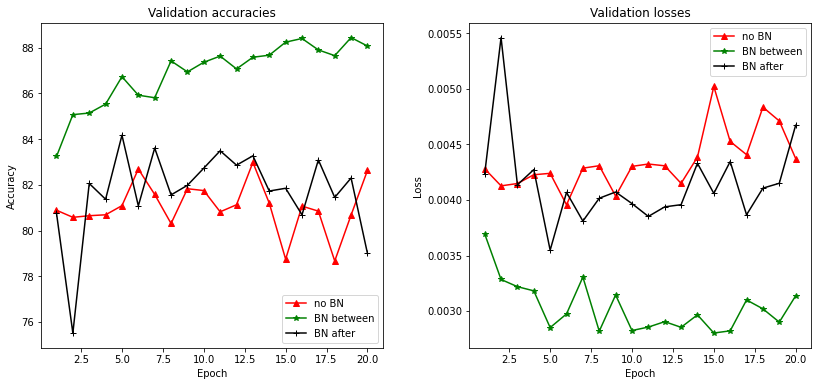

In [6]:
indicies = torch.arange(epochs)+1

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(indicies, accuracies_noBN, "r^", ls="-", label="no BN")
ax1.plot(indicies, accuracies_betweenBN, "g*", ls="-", label="BN between")
ax1.plot(indicies, accuracies_afterBN, "k+", ls="-", label="BN after")
ax1.set_title("Validation accuracies")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="lower right")

ax2.plot(indicies, losses_noBN, "r^", ls="-", label="no BN")
ax2.plot(indicies, losses_betweenBN, "g*", ls="-", label="BN between")
ax2.plot(indicies, losses_afterBN, "k+", ls="-", label="BN after")
ax2.set_title("Validation losses")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")

fig.set_size_inches(12, 6)
fig.tight_layout(pad=3.0)

Comments: BN between performs better than no batch normalization or batch normalization after the nonlinearity, as expected. By perform better, I mean that for the same amount of training time, batch normalization gives lower validation loss, and more importantly from the practical perspective, higher accuracy. A fairer comparison (to account for the stochasticity in Adam and the randomness of the initializations of the parameters) would be to run this same experiment multiple times and report the average accuracy and validation loss per epoch over all the experiments.

Shuffling is important because without it, each example would be seen as part of the same minibatch in all epochs. If the data were well mixed to begin with, this wouldn't be problematic, but if the data were not well-mixed, it would be difficult for batch normalization to work as the different minibatches would have very different statistics, so expecting to learn a shift and scale that works for them all doesn't seem reasonable.